In [71]:
#pip install sidetable --quiet

In [72]:
#pip install dataprep --quiet

In [73]:
#pip install plotly --quiet

In [74]:
#pip install quantiphy

In [1]:
# import important libraries that would be needed in the project
import scipy.stats as stats
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import quantities as pq
from quantiphy import Quantity
import plotly.express as px
from dataprep.clean import clean_country, clean_df, validate_lat_long, clean_headers
%matplotlib inline

In [76]:
# import the africa food production dataset for the years 2004 to 2013
prod = pd.read_csv("production.csv")
print(prod.shape)
prod.head()

(23110, 4)


,Country,Item,Year,Value
0,Algeria,Wheat and products,2004,2731
1,Algeria,Wheat and products,2005,2415
2,Algeria,Wheat and products,2006,2688
3,Algeria,Wheat and products,2007,2319
4,Algeria,Wheat and products,2008,1111


In [3]:
# general overview of the production dataset
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23110 entries, 0 to 23109
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  23110 non-null  object
 1   Item     23110 non-null  object
 2   Year     23110 non-null  int64 
 3   Value    23110 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 722.3+ KB


In [4]:
# descriptive statistics of the production dataset
prod.describe()

,Year,Value
count,23110.000000,23110.000000
mean,2008.498269,327.785201
std,2.871740,1607.940343
min,2004.000000,0.000000
25%,2006.000000,3.000000
50%,2008.000000,18.000000
75%,2011.000000,108.000000
max,2013.000000,54000.000000


In [5]:
# check for duplicate entries in the production dataset
prod.duplicated().sum()

0

In [6]:
# all unique food or food product types
prod.Item.unique()

array(['Wheat and products', 'Rice (Milled Equivalent)',
       'Barley and products', 'Maize and products', 'Oats',
       'Sorghum and products', 'Cereals, Other', 'Potatoes and products',
       'Sugar beet', 'Sugar (Raw Equivalent)', 'Honey', 'Beans', 'Peas',
       'Pulses, Other and products', 'Nuts and products',
       'Groundnuts (Shelled Eq)', 'Sunflower seed',
       'Rape and Mustardseed', 'Cottonseed',
       'Olives (including preserved)', 'Groundnut Oil',
       'Sunflowerseed Oil', 'Rape and Mustard Oil', 'Olive Oil',
       'Oilcrops Oil, Other', 'Tomatoes and products', 'Onions',
       'Vegetables, Other', 'Oranges, Mandarines',
       'Lemons, Limes and products', 'Grapefruit and products',
       'Citrus, Other', 'Bananas', 'Apples and products', 'Dates',
       'Grapes and products (excl wine)', 'Fruits, Other', 'Pimento',
       'Wine', 'Beer', 'Beverages, Alcoholic', 'Bovine Meat',
       'Mutton & Goat Meat', 'Pigmeat', 'Poultry Meat', 'Meat, Other',
       'Of

In [7]:
# Which country produced the highest amount of Oats in 2010?
data = prod[prod.Item == 'Oats']
data = data[data.Year == 2010]
data.sort_values('Value',ascending=False)

,Country,Item,Year,Value
46,Algeria,Oats,2010,88
6406,Ethiopia,Oats,2010,48
13186,Morocco,Oats,2010,37
17816,South Africa,Oats,2010,34
9286,Kenya,Oats,2010,3
20056,Tunisia,Oats,2010,2
22516,Zimbabwe,Oats,2010,1
7746,Ghana,Oats,2010,0
10026,Lesotho,Oats,2010,0


In [8]:
# Which three countries have produced the highest quantity of Rice from 2004 to 2013
data = prod[prod.Item == 'Rice (Milled Equivalent)']
data[['Country','Value']].groupby('Country').sum().sort_values('Value',ascending=False)

,Value
Country,
Egypt,40370
Nigeria,26964
Madagascar,26118
United Republic of Tanzania,10956
Guinea,10400
Mali,10371
Cote d'Ivoire,6439
Sierra Leone,6038
Senegal,2462


In [10]:
# create a physical quantity object in Kilotonnes
prod.Value = pq.Quantity(prod.Value,'kt')
prod.head()

,Country,Item,Year,Value
0,Algeria,Wheat and products,2004,2731 kt
1,Algeria,Wheat and products,2005,2415 kt
2,Algeria,Wheat and products,2006,2688 kt
3,Algeria,Wheat and products,2007,2319 kt
4,Algeria,Wheat and products,2008,1111 kt


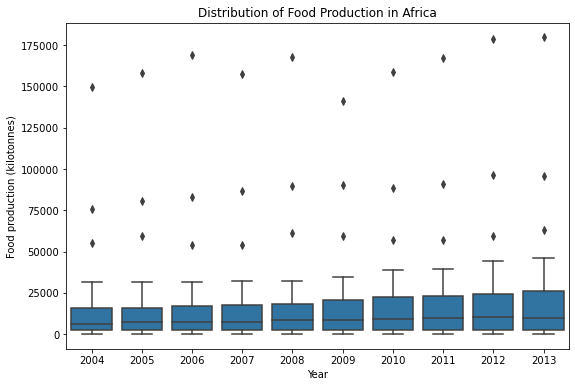

In [18]:
# a boxplot to show the distribution of food production in africa over the years
year_group = prod.groupby(['Country','Year']).sum().reset_index()
plt.figure(figsize=[9,6])
sns.boxplot(data=year_group,x='Year',y='Value',color=sns.color_palette()[0]);
plt.title('Distribution of Food Production in Africa');
plt.ylabel('Food production (kilotonnes)');

There are three upper outliers for each year since 2004 till 2013. It is interesting to investigate further which countries are responsible for the outliers for each year.

In [21]:
outlier_countries = {}
for year in year_group.Year.unique():
    data = year_group[year_group.Year == year]
    upper = np.quantile(data.Value,0.75)
    lower = np.quantile(data.Value,0.25)
    fence = upper + 1.5*(upper-lower)
    countries = list(data.Country[data.Value > fence])
    outlier_countries[year] = countries
outlier_countries

{2004: ['Egypt', 'Nigeria', 'South Africa'],
 2005: ['Egypt', 'Nigeria', 'South Africa'],
 2006: ['Egypt', 'Nigeria', 'South Africa'],
 2007: ['Egypt', 'Nigeria', 'South Africa'],
 2008: ['Egypt', 'Nigeria', 'South Africa'],
 2009: ['Egypt', 'Nigeria', 'South Africa'],
 2010: ['Egypt', 'Nigeria', 'South Africa'],
 2011: ['Egypt', 'Nigeria', 'South Africa'],
 2012: ['Egypt', 'Nigeria', 'South Africa'],
 2013: ['Egypt', 'Nigeria', 'South Africa']}

The same countries were responsible for the outliers from 2004 to 2013, Egypt, Nigeria and South Africa.

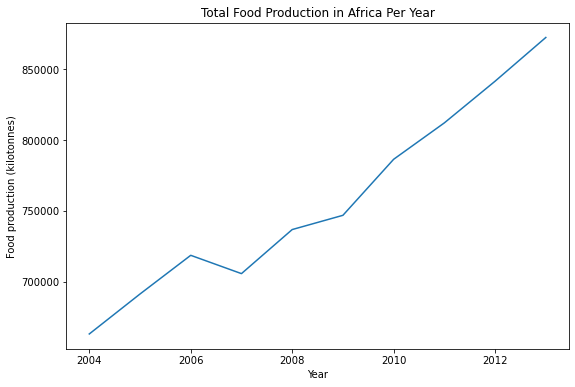

In [49]:
# plot a line graph showing the trend of total food production in africa from 2004 to 2013
trend = prod[['Year','Value']].groupby('Year').agg([np.sum,np.mean]).Value.reset_index()
fig, ax = plt.subplots(figsize=[9,6])
ax = sns.lineplot(data=trend,x='Year',y='sum');
plt.ylabel('Food production (kilotonnes)');
plt.title('Total Food Production in Africa Per Year');

In [136]:
# mean food production per year in africa
trend['sum'].mean()

757511.6

In [138]:
trend['sum'].median()

741837.0

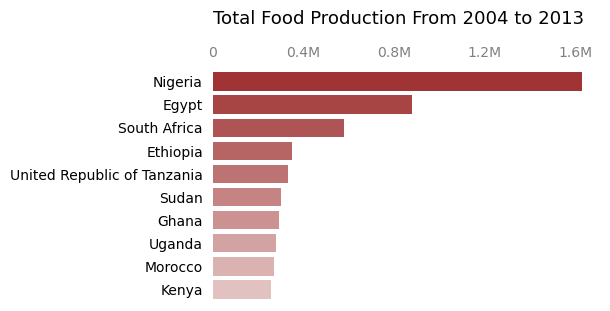

In [104]:
# plot a bar chart to show the most productive countries since 2004
top_countries = prod[['Country','Value']].groupby('Country').sum().reset_index().sort_values('Value',ascending=False)[:10]
plt.style.use('default')
fig, ax = plt.subplots(figsize=[5,3])
ax = sns.barplot(data=top_countries,y='Country',x='Value',color='#B22222')
ax.set_xlabel('')
ax.set_ylabel('')
for loc in ['right','left','top','bottom']:
    ax.spines[loc].set_visible(False)
for bar, alpha in zip(ax.containers[0],np.linspace(1,0.3,10)):
    bar.set_alpha(alpha)
ax.set_xticks([0,400000,800000,1200000,1600000])
ax.set_xticklabels(['0','0.4M','0.8M','1.2M','1.6M'])
ax.xaxis.tick_top()
ax.tick_params(left=False,top=False)
ax.tick_params(axis='x',colors='grey')
ax.text(0,-2.5,'Total Food Production From 2004 to 2013',size=13);

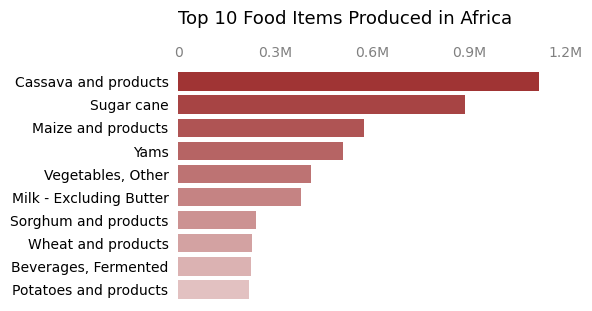

In [107]:
top_items = prod[['Item','Value']].groupby('Item').sum().reset_index().sort_values('Value',ascending=False)[:10]
fig, ax = plt.subplots(figsize=[5,3])
ax = sns.barplot(data=top_items,y='Item',x='Value',color='#B22222')
ax.set_xlabel('')
ax.set_ylabel('')
for loc in ['right','left','top','bottom']:
    ax.spines[loc].set_visible(False)
for bar, alpha in zip(ax.containers[0],np.linspace(1,0.3,10)):
    bar.set_alpha(alpha)
ax.set_xticks([0,300000,600000,900000,1200000])
ax.set_xticklabels(['0','0.3M','0.6M','0.9M','1.2M'])
ax.xaxis.tick_top()
ax.tick_params(left=False,top=False)
ax.tick_params(axis='x',colors='grey')
ax.text(0,-2.5,'Top 10 Food Items Produced in Africa',size=13);

In [111]:
# investigate the countries producing the top 10 food items
item_countries = list(prod.Country[prod.Item.isin(['Cassava and products','Sugar cane',
                                                   'Maize and products','Yams','Vegetables, Other','Milk - Excluding Butter',
                                                   'Sorghum and products','Wheat and products','Beverages, Fermented',
                                                   'Potatoes and products'])].unique())
len(item_countries)

45

In [114]:
# investigate the highest producers of the top 10 food items
top_items = prod[prod.Item.isin(['Cassava and products','Sugar cane',
                                                   'Maize and products','Yams','Vegetables, Other','Milk - Excluding Butter',
                                                   'Sorghum and products','Wheat and products','Beverages, Fermented',
                                                   'Potatoes and products'])]
top_items_group = top_items[['Country','Value']].groupby('Country').sum().reset_index().sort_values('Value',ascending=False)
top_items_group

,Country,Value
31,Nigeria,1163595
12,Egypt,496656
36,South Africa,382880
37,Sudan,211211
16,Ghana,199823
42,United Republic of Tanzania,197043
13,Ethiopia,187697
19,Kenya,180820
1,Angola,147346
41,Uganda,144745


In [117]:
country_to_item = pd.pivot_table(top_items,values='Value',index='Country',columns='Item',aggfunc=np.sum).dropna(axis=0)
country_to_item

Item,"Beverages, Fermented",Cassava and products,Maize and products,Milk - Excluding Butter,Potatoes and products,Sorghum and products,Sugar cane,"Vegetables, Other",Wheat and products,Yams
Country,,,,,,,,,,
Cameroon,9829.0,32904.0,14246.0,2352.0,1679.0,9618.0,12677.0,12045.0,10.0,4358.0
Chad,185.0,2500.0,2253.0,2614.0,474.0,6834.0,3892.0,895.0,100.0,3402.0
Kenya,2410.0,6624.0,30328.0,44899.0,23730.0,1281.0,53094.0,14714.0,3663.0,77.0
Mali,741.0,575.0,10581.0,12932.0,994.0,9931.0,3557.0,6517.0,185.0,695.0
Nigeria,93839.0,452881.0,76898.0,4880.0,9657.0,78915.0,12840.0,83335.0,831.0,349519.0
Rwanda,883.0,17414.0,3037.0,1891.0,15622.0,1671.0,898.0,4286.0,538.0,238.0
Sudan,7576.0,125.0,548.0,70527.0,3155.0,38735.0,69371.0,14836.0,4836.0,1502.0
United Republic of Tanzania,25285.0,52057.0,43166.0,16762.0,10260.0,7599.0,26150.0,14797.0,875.0,92.0


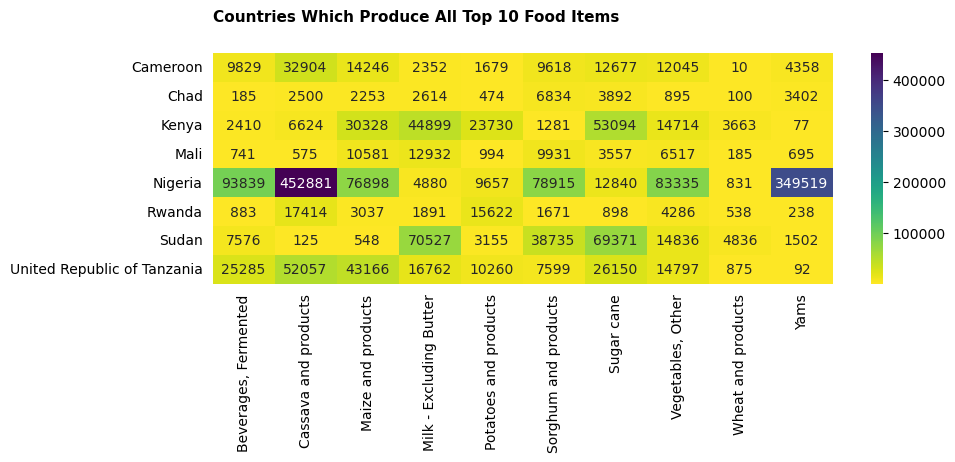

In [123]:
fig, ax = plt.subplots(figsize=[10,3])
ax = sns.heatmap(data=country_to_item,cmap='viridis_r',annot=True,fmt='g')
ax.tick_params(left=False,bottom=False)
ax.set_xlabel("");
ax.set_ylabel("");
ax.text(.0,-1.1,'Countries Which Produce All Top 10 Food Items',size=11,weight='bold');

In [50]:
# import the afric food supply dataset for the years 2004 to 2013
supply = pd.read_csv("supply.csv")
supply.head()

,Country,Year,Value
0,Algeria,2004,2987
1,Algeria,2005,2958
2,Algeria,2006,3047
3,Algeria,2007,3041
4,Algeria,2008,3048


In [77]:
supply.shape

(450, 3)

In [51]:
# general overview of the food supply/consumption dataset
supply.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  450 non-null    object
 1   Year     450 non-null    int64 
 2   Value    450 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 10.7+ KB


In [52]:
# check for duplicate entries in the food supply/consumption dataset
supply.duplicated().sum()

0

In [53]:
# descriptive statistics of the food supply/consumption dataset
supply.describe()

,Year,Value
count,450.000000,450.000000
mean,2008.500000,2469.775556
std,2.875478,379.140143
min,2004.000000,1781.000000
25%,2006.000000,2174.000000
50%,2008.500000,2376.000000
75%,2011.000000,2681.750000
max,2013.000000,3561.000000


In [54]:
# total number of african countries in the food consumption/supply dataset
supply.Country.nunique()

45

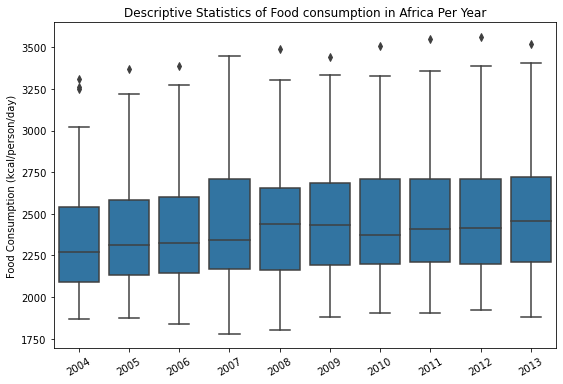

In [56]:
# check for outliers in the supply dataset using boxplot
plt.figure(figsize=[9,6])
sns.boxplot(data=supply,x='Year',y='Value',color=sns.color_palette()[0])
plt.xticks(rotation=30);
plt.ylabel('Food Consumption (kcal/person/day)');
plt.xlabel('');
plt.title('Descriptive Statistics of Food consumption in Africa Per Year');

All years apart from 2004 and 2007 have just one outlier. In 2004, there were three outliers, and there were no outliers in 2007. It would also be interesting to investigate the countries responsible for these outliers.

In [58]:
# countries with the outliers for each year
year_countries = {}
for year in supply.Year.unique():
    data = supply[supply.Year == year]
    upper = np.quantile(data.Value,0.75)
    lower = np.quantile(data.Value,0.25)
    fence = upper + 1.5*(upper - lower)
    countries = list(data.Country[data.Value>fence])
    year_countries[year] = countries
year_countries

{2004: ['Egypt', 'Morocco', 'Tunisia'],
 2005: ['Egypt'],
 2006: ['Egypt'],
 2007: [],
 2008: ['Egypt'],
 2009: ['Egypt'],
 2010: ['Egypt'],
 2011: ['Egypt'],
 2012: ['Egypt'],
 2013: ['Egypt']}

Egypt, Morocco and Tunisia, all north american countries, were responsible for the outliers in 2004. Egypt was responsible for the outliers in other years.

In [60]:
# Which three countries had the lowest food supply between 2004 and 2006 respectively(inclusive)
data = supply[(supply.Year >= 2004)&(supply.Year <=2006)]
data.groupby('Country').sum().sort_values('Value')

,Year,Value
Country,,
Zambia,6015,5577
Ethiopia,6015,5827
Central African Republic,6015,6044
Rwanda,6015,6050
Chad,6015,6082
Madagascar,6015,6123
Zimbabwe,6015,6184
Mozambique,6015,6208
Angola,6015,6226


In [131]:
# table showing the mean, median, maximum, and minimum food consumption in africa from 2004 - 2013
agg = supply.groupby('Year').agg([np.mean,np.median,np.sum]).Value.reset_index()
agg

C:\Users\HP\AppData\Local\Temp\ipykernel_21396\844674061.py:2: FutureWarning: ['Country'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  agg = supply.groupby('Year').agg([np.mean,np.median,np.sum]).Value.reset_index()


,Year,mean,median,sum
0,2004,2394.222222,2271.0,107740
1,2005,2409.288889,2311.0,108418
2,2006,2430.800000,2325.0,109386
3,2007,2447.755556,2344.0,110149
4,2008,2460.755556,2439.0,110734
5,2009,2482.222222,2435.0,111700
6,2010,2497.400000,2370.0,112383
7,2011,2515.422222,2407.0,113194
8,2012,2527.644444,2414.0,113744
9,2013,2532.244444,2456.0,113951


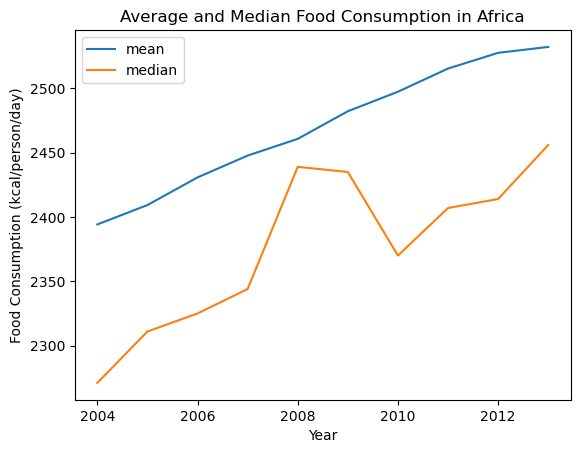

In [132]:
for col in agg.columns[1:3]:
    sns.lineplot(data=agg,x='Year',y=col,label=col)
plt.legend()
plt.ylabel('Food Consumption (kcal/person/day)');
plt.title('Average and Median Food Consumption in Africa');

In [145]:
# countries with the highest food consumption from 2004 to 2013
tot_consumption = supply[['Country','Value']].groupby('Country').sum().reset_index().sort_values('Value',ascending=False)[:10]
tot_consumption

,Country,Value
12,Egypt,34580
40,Tunisia,33055
27,Morocco,32967
0,Algeria,31118
26,Mauritius,30543
36,South Africa,29629
16,Ghana,29180
10,Cote d'Ivoire,27666
24,Mali,27502
25,Mauritania,27443


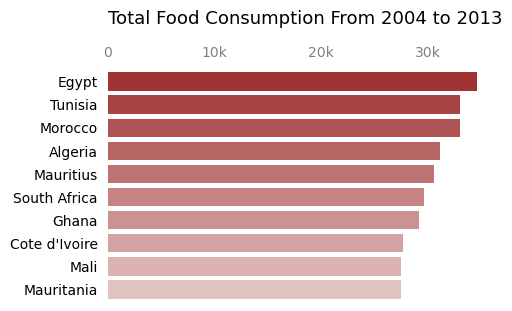

In [150]:
# bar chart showing the top 1o countries in terms of food consumption
fig, ax = plt.subplots(figsize=[5,3])
ax = sns.barplot(data=tot_consumption,y='Country',x='Value',color='#B22222')
ax.set_xlabel('')
ax.set_ylabel('')
for loc in ['right','left','top','bottom']:
    ax.spines[loc].set_visible(False)
for bar, alpha in zip(ax.containers[0],np.linspace(1,0.3,10)):
    bar.set_alpha(alpha)
ax.set_xticks([0,10000,20000,30000])
ax.set_xticklabels(['0','10k','20k','30k'])
ax.xaxis.tick_top()
ax.tick_params(left=False,top=False)
ax.tick_params(axis='x',colors='grey')
ax.text(0,-2.5,'Total Food Consumption From 2004 to 2013',size=13);

In [149]:
# investigate countries present in both top 10 food production and top 10 food consumption
cross = pd.merge(left=top_countries,right=tot_consumption,on='Country',how='inner')
cross.columns = ['Country','prod','consumption']
cross

,Country,prod,consumption
0,Egypt,877498,34580
1,South Africa,579592,29629
2,Ghana,295004,29180
3,Morocco,271821,32967


In [134]:
# combine the dataframes containing average food production and average food consumption for each year
prod_and_supply = pd.merge(left=trend,right=agg,on='Year',how='inner')
prod_and_supply.columns = ['year','total_prod','mean_prod','mean_supply','median_supply','total_supply']
prod_and_supply

,year,total_prod,mean_prod,mean_supply,median_supply,total_supply
0,2004,663006,286.767301,2394.222222,2271.0,107740
1,2005,691257,298.986592,2409.288889,2311.0,108418
2,2006,718602,310.814014,2430.800000,2325.0,109386
3,2007,705659,305.215830,2447.755556,2344.0,110149
4,2008,736804,318.686851,2460.755556,2439.0,110734
5,2009,746870,323.040657,2482.222222,2435.0,111700
6,2010,786466,340.166955,2497.400000,2370.0,112383
7,2011,812214,351.303633,2515.422222,2407.0,113194
8,2012,841667,364.831816,2527.644444,2414.0,113744
9,2013,872571,378.227568,2532.244444,2456.0,113951


In [139]:
# mean food consumption
prod_and_supply.total_supply.mean()

111139.9

In [140]:
# median food consumption
prod_and_supply.total_supply.median()

111217.0

In [135]:
# drop total and median columns in the combined dataset
data = prod_and_supply.drop(['total_prod','median_supply','total_supply'],axis=1)
data

,year,mean_prod,mean_supply
0,2004,286.767301,2394.222222
1,2005,298.986592,2409.288889
2,2006,310.814014,2430.800000
3,2007,305.215830,2447.755556
4,2008,318.686851,2460.755556
5,2009,323.040657,2482.222222
6,2010,340.166955,2497.400000
7,2011,351.303633,2515.422222
8,2012,364.831816,2527.644444
9,2013,378.227568,2532.244444


<Figure size 648x432 with 0 Axes>

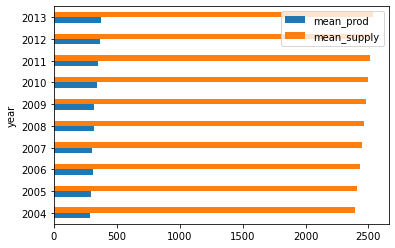

In [74]:
# bar chart to compare mean food production and mean food consumption
plt.figure(figsize=[9,6])
data.plot(x='year',y=['mean_prod','mean_supply'],kind='barh');

In [49]:
# create a physical quantity object in Kcal/person/day
#supply.Value = pq.Quantity(supply.Value,'kcal/person/day')
#supply.head()

In [58]:
# convert the year column in both dataset to datetime data types
#supply.Year = pd.to_datetime(supply.Year,format = '%Y')
#production.Year = pd.to_datetime(production.Year,format = '%Y')